In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = "/content/drive/MyDrive/DL/Project/data/food-ingredients-and-recipe-dataset-with-images.zip"
url = "https://www.kaggle.com/api/v1/datasets/download/pes12017000148/food-ingredients-and-recipe-dataset-with-images"

In [3]:
# download data
import os
import subprocess

def download_data_if_not_exists(data_path, url):
  """Downloads data using curl if it doesn't already exist."""
  if not os.path.exists(data_path):
    print("Data not found. Downloading...")
    subprocess.run(["curl", "-L", "-o", data_path, url], check=True)
    print("Download complete.")
  else:
    print("Data already downloaded.")

# Call the function to download the data if necessary
download_data_if_not_exists(data_path, url)

Data already downloaded.


In [5]:
# unzip data
import os
import zipfile

def unzip_data(zip_path, extract_path):
  """Unzips the data file if it exists."""
  if os.path.exists(zip_path):
    print("Unzipping data...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print("Unzipping complete.")
  else:
    print("Zip file not found. Please download the data first.")

# Call the function to unzip the data if the zip file exists
unzip_data(data_path, "/content/drive/MyDrive/DL/Project/data/")

Unzipping data...
Unzipping complete.


In [2]:
# read data and create train and test text files
import pandas as pd
import re
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/DL/Project/data/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')

def build_text_files(data_csv, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_csv.iterrows():
        ingredients  = str(texts[1]['Ingredients']).strip()[1:-1]
        instructions = str(texts[1]['Instructions']).strip()

        ingredients = re.sub(r"\s", " ", ingredients)
        instructions = re.sub(r"\s", " ", instructions)

        summary = 'Ingredients: ' + ingredients + '\nInstructions: ' + instructions
        data += summary + "\n"
    f.write(data)

train, test = train_test_split(df,test_size=0.15)

build_text_files(train,'/content/drive/MyDrive/DL/Project/data/train_dataset.txt')
build_text_files(test,'/content/drive/MyDrive/DL/Project/data/test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))

# Train dataset length: 11475
# Test dataset length: 2026

Train dataset length: 11475
Test dataset length: 2026


In [3]:
# load the data into huggingface datasets and create model and tokenizer
from transformers import TextDataset,DataCollatorForLanguageModeling
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_path = '/content/drive/MyDrive/DL/Project/data/train_dataset.txt'
test_path = '/content/drive/MyDrive/DL/Project/data/test_dataset.txt'

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)

    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
# trainig step
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/DL/Project/gpt2-recipe",            # Directory to save the model
    num_train_epochs=10,                    # Number of training epochs
    per_device_train_batch_size=8,         # Batch size
    per_device_eval_batch_size=8,          # Evaluation batch size
    logging_dir='/content/drive/MyDrive/DL/Project/logs',                  # Directory for logging
    # save_steps=500,                        # Save the model every N steps
    save_strategy='no',
    eval_strategy="epoch",           # Evaluate every N steps
    logging_steps=100,                     # Log every N steps
    warmup_steps=200,                      # Warm-up steps for learning rate scheduler
    weight_decay=0.01,                     # Weight decay
    logging_first_step=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # Optional: You can provide a validation dataset if available
    data_collator=data_collator,
)

initial_validation = trainer.evaluate()
trainer.train()
final_validation = trainer.evaluate()

print(f"Initial validation loss: {initial_validation['eval_loss']}")
print(f"Final validation loss: {final_validation['eval_loss']}")

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,1.953600,1.897520,0.008600
2,1.845600,1.810624,0.008600
3,1.766700,1.763355,0.008600


In [ ]:
import json
with open("/content/drive/MyDrive/DL/Project/logs/log_data.json", 'w') as f:
    json.dump(trainer.state.log_history, f, indent=4)

print(f"Training logs saved to logs")

Training logs saved to logs


In [7]:
import json

# Specify the path to your JSON file
file_path = '/content/drive/MyDrive/DL/Project/logs/log_data.json'  # Replace with the actual path

# Open the file in read mode ('r')
with open(file_path, 'r') as f:
    # Load the JSON data into a Python object (usually a dictionary or list)
    train_logs = json.load(f)

print(train_logs)

[{'loss': 3.2557, 'grad_norm': 8.869467735290527, 'learning_rate': 2.5000000000000004e-07, 'epoch': 0.0002449179524859172, 'step': 1}, {'loss': 2.9081, 'grad_norm': 6.846681118011475, 'learning_rate': 2.5e-05, 'epoch': 0.02449179524859172, 'step': 100}, {'loss': 2.605, 'grad_norm': 7.053561210632324, 'learning_rate': 5e-05, 'epoch': 0.04898359049718344, 'step': 200}, {'loss': 2.5187, 'grad_norm': 5.487305164337158, 'learning_rate': 4.987693822298794e-05, 'epoch': 0.07347538574577517, 'step': 300}, {'loss': 2.4255, 'grad_norm': 5.6913981437683105, 'learning_rate': 4.975387644597588e-05, 'epoch': 0.09796718099436688, 'step': 400}, {'loss': 2.4077, 'grad_norm': 5.014596462249756, 'learning_rate': 4.9630814668963824e-05, 'epoch': 0.12245897624295861, 'step': 500}, {'loss': 2.3397, 'grad_norm': 4.184401512145996, 'learning_rate': 4.9507752891951764e-05, 'epoch': 0.14695077149155034, 'step': 600}, {'loss': 2.3302, 'grad_norm': 4.293142795562744, 'learning_rate': 4.9384691114939705e-05, 'epoc

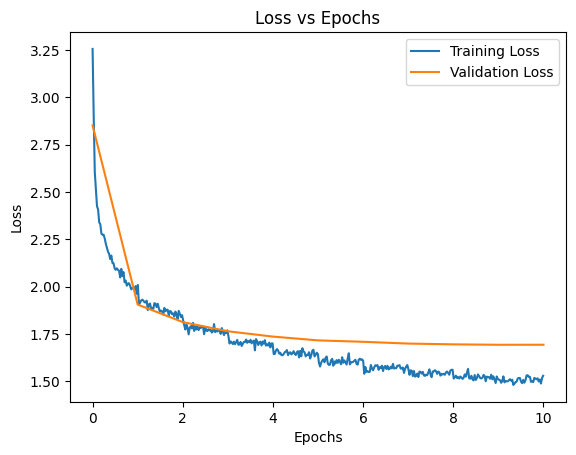

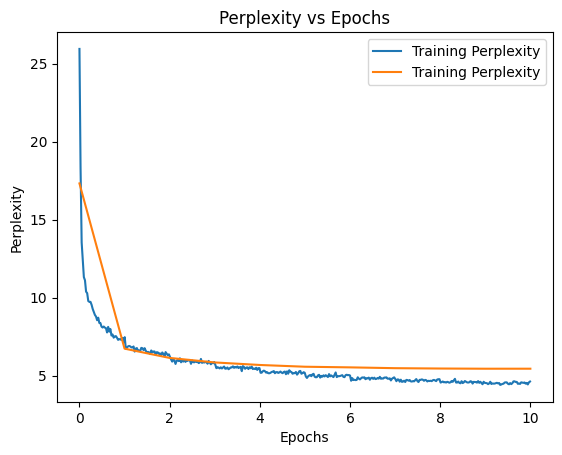

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store loss and perplexity values
train_x_axis = []
val_x_axis = []
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

val_x_axis.append(0)
val_losses.append(initial_validation['eval_loss'])
val_perplexities.append(np.exp(initial_validation['eval_loss']))  # Calculate perplexity as exp(loss)

# Loop through the logs and capture the loss values
for log in train_logs:
    if 'eval_loss' in log:
        val_x_axis.append(log['epoch'])
        val_losses.append(log['eval_loss'])
        val_perplexities.append(np.exp(log['eval_loss']))  # Calculate perplexity as exp(loss)
    elif 'loss' in log:
        train_x_axis.append(log['epoch'])
        train_losses.append(log['loss'])
        train_perplexities.append(np.exp(log['loss']))  # Calculate perplexity as exp(loss)

fig, ax = plt.subplots()

# Plot Loss
ax.plot(train_x_axis, train_losses, label='Training Loss')
ax.plot(val_x_axis, val_losses, label='Validation Loss')
ax.set_title('Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
fig.show()

fig, ax = plt.subplots()

# Plot Perplexity
ax.plot(train_x_axis, train_perplexities, label='Training Perplexity')
ax.plot(val_x_axis, val_perplexities, label='Training Perplexity')
ax.set_title('Perplexity vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Perplexity')
ax.legend()
fig.show()
